## Classifying MNIST with Le-Net (MyGrad and MyNN)

In this notebook, we will be training a convolutional neural network (using a slightly modernized version of the seminal "Le-Net" design described in [this paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) to classify hand-written digits. We will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which contains labeled images of hand-written digits from 0 to 9 . The MNIST dataset has a training set of 60,000 images and a test set of 10,000 images. 

When working through the tendril dataset, you worked through creating a 2 layer dense network with and without MyNN so you should have a feel for how to work with it by now. If you haven't already, which shouldn't be possible, you should install MyNN:

``` bash
$ git clone https://github.com/davidmascharka/MyNN
$ cd MyNN
$ python setup.py develop
```

You should also have downloaded the [DataSets repo](https://github.com/LLCogWorks2018/DataSets), installed it, and set it up using `python setup.py develop` within that directory. This provides you with the ability to download and load the mnist dataset, which we will use below.

We will be using a modified-LeNet architecture, which was one of the first convolutional neural network designs. The architecture is:

- conv w/ 5x5 kernel, stride-1
- pool w/ 2x2 window, stride-2
- conv w/ 5x5 kernel, stride-1
- pool w/ 2x2 window, stride-2
- relu(dense)
- softmax(dense)

Note that you will omit the final softmax, as we will be using the softmax-crossentropy loss. Notice that the convs/pools do not have any activations associated with them!

In [56]:
import numpy as np
import mygrad as mg
from mygrad import Tensor

try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

import liveplot
%matplotlib notebook
import matplotlib.pyplot as plt
from random import randint

### MNIST Data Loading and preprocessing

First, we will load in our data using handy functions from the datasets repo. If you haven't already, download the data by calling `download_mnist()`

In [57]:
from datasets import load_mnist, download_mnist

Each image in the mnist dataset is 1x28x28 - these are greyscale images, so they only have one color channel instead of three (RGB). The LeNet paper adds zero-padding to these images so that each image becomes 1x32x32. We will do the same below using `numpy.pad`.

In [59]:
#load the data set (read the documentation for how to unpack the returned values)
download_mnist()
x_train, y_train, x_test, y_test = load_mnist()
print(x_train.shape)
#scale down the training and testing data between 0 and 1 where 0 is white and 1 is black
#figure out the range of values currently in your data you know what scaling factor to use
#make sure that the data remains of type np.float32
#this is a form of precprocessing that involves transforming our raw data into an understandable format
x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")
x_test = np.pad(x_test, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")



File already exists:
	C:\Users\Andrew\datasets\mnist.npz
mnist loaded
(60000, 1, 28, 28)


Number:8


<IPython.core.display.Javascript object>


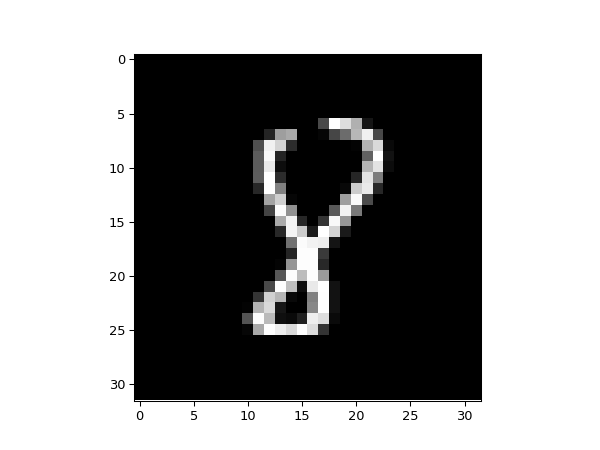

In [60]:
# Try plotting some of the training data. Because these are grayscale images, matplotlib
# wants an array of shape (H, W), not (1, H, W)
r = randint(0,len(y_test) -1)
print("Number:" + str(y_train[r]))
fig, ax = plt.subplots()
ax.imshow(x_train[r, 0], cmap="gray");


What are the range of pixel-values present in the images in MNIST? Because this is a simple dataset (each image is mostly blank background), we don't have to center our data, we can simply scale it so that all of the values reside on [0, 1]. (Note that 0-centering and normalizing by the standard deviation will still work perfectly well!)

Change the data type of `x_train` and `x_test` to be float-32 and normalize your data as we just discussed. Print the shape and data type of each array to confirm that they are appropriate (labels should be integers!)

In [61]:
# STUDENT CODE
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train / 255
x_test = x_test / 255


Similarly to our tendril dataset, we need to define a function that can measure the accuracy of our predictions

Now you will construct your model. A sensible starting point for your number of filters is F=10 for your first conv-layer and F=20 for your second conv layer. Experiment with the size for your dense layer. 

You will need to calculate of the dimensionality of the tensor that is coming into your first dense layer. For example, if your last conv produced an output of shape (N, 20, 6, 6), then that output needs to be flattened to a tensor of shape (N, 720). And thus your dense layer should anticipate an input of dimensionality 720.

Initialize your convolution and dense layers as class attributes using the functions imported from MyNN, using weight_initializer=`glorot_uniform` for all 4 layers. You can import this with

```python
from mynn.initializers.glorot_uniform import glorot_uniform
```

If you would like to read more about how Xavier Glorot explains the rationalization behind these weight initializations,
look [here for his paper written with Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). 


In [62]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

Create your model

In [63]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mygrad.nnet.layers import max_pool
from mynn.initializers.glorot_uniform import glorot_uniform
from mynn.activations.relu import relu

class Model:
    ''' A simple convolutional neural network. '''
    def __init__(self):
        # - conv w/ 5x5 kernel, stride-1
        # - pool w/ 2x2 window, stride-2
        # - conv w/ 5x5 kernel, stride-1
        # - pool w/ 2x2 window, stride-2
        # - relu(dense)
        # - dense
        
        # initialize your convolution and dense layers. As mentioned above, you 
        # will need to compute the dimensionality of the tensor that will go
        # into your first dense layer.
        
        # there is no need to initialize any pooling layer, as are no trainable
        # parameters associated with pooling
        
        ########################################STUDENT CODE##################################
        #To add more layers, call the self.name of layer = dense(size of previous layers, new size, 
        #weight_initializer=glorot_uniform)
        self.conv1 = conv(1,20,(5,5),stride=(1,1),weight_initializer=glorot_uniform)
        self.conv2 = conv(20,10,(5,5),stride=(1,1),weight_initializer=glorot_uniform)
        self.dense1 = dense(250,100, weight_initializer=glorot_uniform)
        self.dense2 = dense(100,10,weight_initializer=glorot_uniform)
        
        
    
    def __call__(self, x):
        ''' Defines a forward pass of the model.
        
        Parameters
        ----------
        x : numpy.ndarray, shape=(N, 1, 32, 32)
            The input data, where N is the number of images.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 10)
            The class scores for each of the N images.
        '''
        
        # write your forward pass function, passing the data, `x` to 
        # the first conv, then the max_pool, and so on.
        # Your final dense layer should not have a softmax applied
        # to it since we will be using the `softmax_crossentropy` loss.
        
        ########################################STUDENT CODE##################################
        #Add x = self.name of layer(relu(x)) for each extra layer 
        x = max_pool(self.conv1(x),(2,2),(2,2))
        x = max_pool(self.conv2(x),(2,2),(2,2)).reshape(len(x),-1)
        x = self.dense1(x)
        x = self.dense2(relu(x))

        return x
        
    
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        # This function should return a tuple of all of the trainable parameters of
        # your model. Recall that MyNN nicely gives you access to each layer's parameters:
        # `layer.paramters` will return a tuple of the parameters for a given layer. 
        # E.g. `dense_layer.parameters` -> (w, b)
        
        ########################################STUDENT CODE##################################
        #Add + self.name of layer.paramters for each extra layer to the return statement
        return self.conv1.parameters + self.conv2.parameters + self.dense1.parameters + self.dense2.parameters
        

Now import the `SGD` (stochastic gradient descent) optimizer from MyNN and initialize your optimizer, giving it all of your model parameters. You will also specify a learning rate, a weight decay parameter, and a *momentum* parameter. This will updated your model's parameters based on a *running mean* of their past gradients:

\begin{equation}
v = \mu v - \delta\frac{dL}{dw} \\
w = w +  v
\end{equation}

Where $\mu$ is the momentum and $\delta$ is the learning-rate, and $w$ is the model parameter being updated. $v$ is initialliy 0. See that setting momentum ($\mu$) to 0 reproduces vanilla gradient descent. *A sensible momentum value is `momentum=0.9`*. This will help make your gradient descent less sensitive to small bumps/noise in the loss curve.


Initialize your optimizer. Sensible hyper parameters are:

- learning_rate=0.01
- momentum=0.9
- weight_decay=5e-4

In [64]:
# STUDENT CODE
model = Model()
from mynn.optimizers.sgd import SGD
########################################STUDENT CODE##################################
optim = SGD(model.parameters,learning_rate=0.01,momentum=0.9,weight_decay=5e-4) #change 0.01 to change learning rate

Initialize your live-plot.

<IPython.core.display.Javascript object>


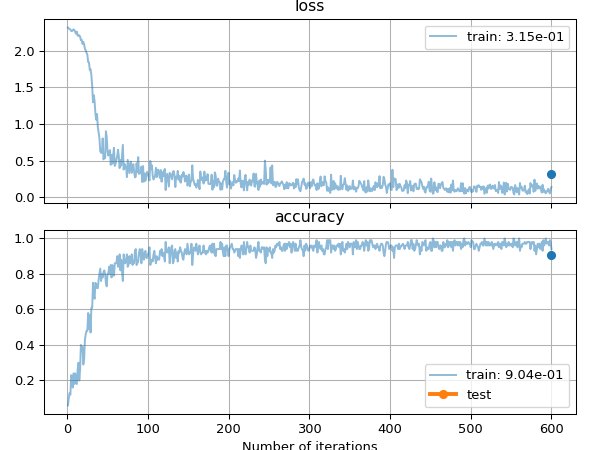

In [65]:
# STUDENT CODE
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

Initialize your model, and optimizer and begin training your model. A batch size of 100 is reasonable. This model can be a bit slow to run, so you might want to plot your test-performance more frequently than once per epoch - that way you can see what the generalized performance of your network is sooner.

In [66]:
# STUDENT CODE
from mynn.losses.cross_entropy import softmax_cross_entropy
########################################STUDENT CODE##################################
batch_size = 100 #change 100 to change batch size


# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(1):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    
    for batch_cnt in range(0, len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_train[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        # compute the true (a.k.a desired) values for this batch: 
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        # back-propagate through your computational graph through your loss
        # compute the accuracy between the prediction and the truth 
        # execute gradient descent by calling step() of `optim`
        # null your gradients (please!)
        prediction = model(batch) #our forward pass through every layer is done utilizing the model class written above
        truth = y_train[batch_indices]
        
        loss = softmax_cross_entropy(prediction, truth)
        acc = accuracy(prediction, truth)
        loss.backward()
        
        optim.step()
        loss.null_gradients()
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(x_test)//batch_size):
        idxs = np.arange(len(x_test))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_test[batch_indices] 
        
        # get your model's prediction on the test-batch
        # get the truth values for that test-batch
        # compute the test accuracy
        prediction = model(batch)
        truth = y_test[batch_indices]
        acc = accuracy(prediction,truth)
        # DO NOT back-prop or do gradient descent!
        
        # log the test-accuracy in liveplot for each-
        plotter.set_test_batch({ "accuracy" : acc,},
                                 batch_size=batch_size)
    # this tells liveplot to plot the epoch-level train/test statistics :)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()    

In [71]:
batch.shape

(100, 1, 32, 32)

In [74]:
model()

Tensor([[-0.39078153,  1.31374107,  4.50919317,  7.7525047 , -7.99084963,
          8.96055981, -3.52437521,  1.72935417,  2.49740237,  0.25682059]])

Actual Number:3
Predicted Number:3


<IPython.core.display.Javascript object>


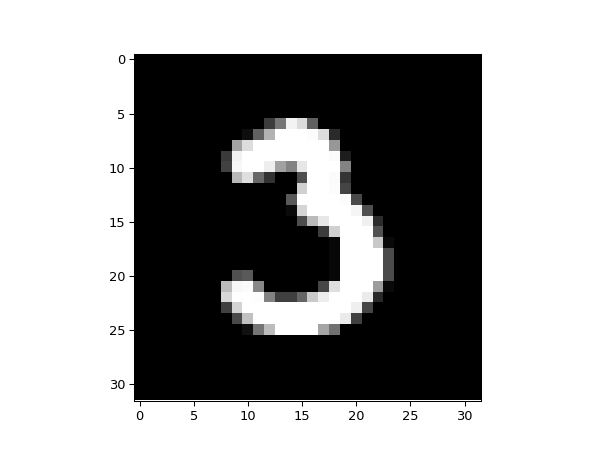

In [112]:
# Try plotting some of the training data. Because these are grayscale images, matplotlib
# wants an array of shape (H, W), not (1, H, W)
r = randint(0,len(y_test)-1)
print("Actual Number:" + str(y_test[r]))
print("Predicted Number:" + str(np.argmax(model(x_test[r,0].reshape(1,1,32,32)))))
fig, ax = plt.subplots()
ax.imshow(x_test[r, 0], cmap="gray");
